In [1]:
from datasets import load_dataset

dataset = load_dataset('TheNoob3131/mosquito-data')
#, column_names=['MHM ID','Classification', 'Container', 'Userid', 'latitude', 'longitude', 'date', 'Photo']

Using custom data configuration TheNoob3131--mosquito-data-bf1f4d4d5f427763


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to C:\Users\Aswin.Surya24\.cache\huggingface\datasets\TheNoob3131___csv\TheNoob3131--mosquito-data-bf1f4d4d5f427763\0.0.0\51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
dataset['train'].features['Photo']
from datasets import Image
dataset = dataset.cast_column('Photo', Image(decode=True))

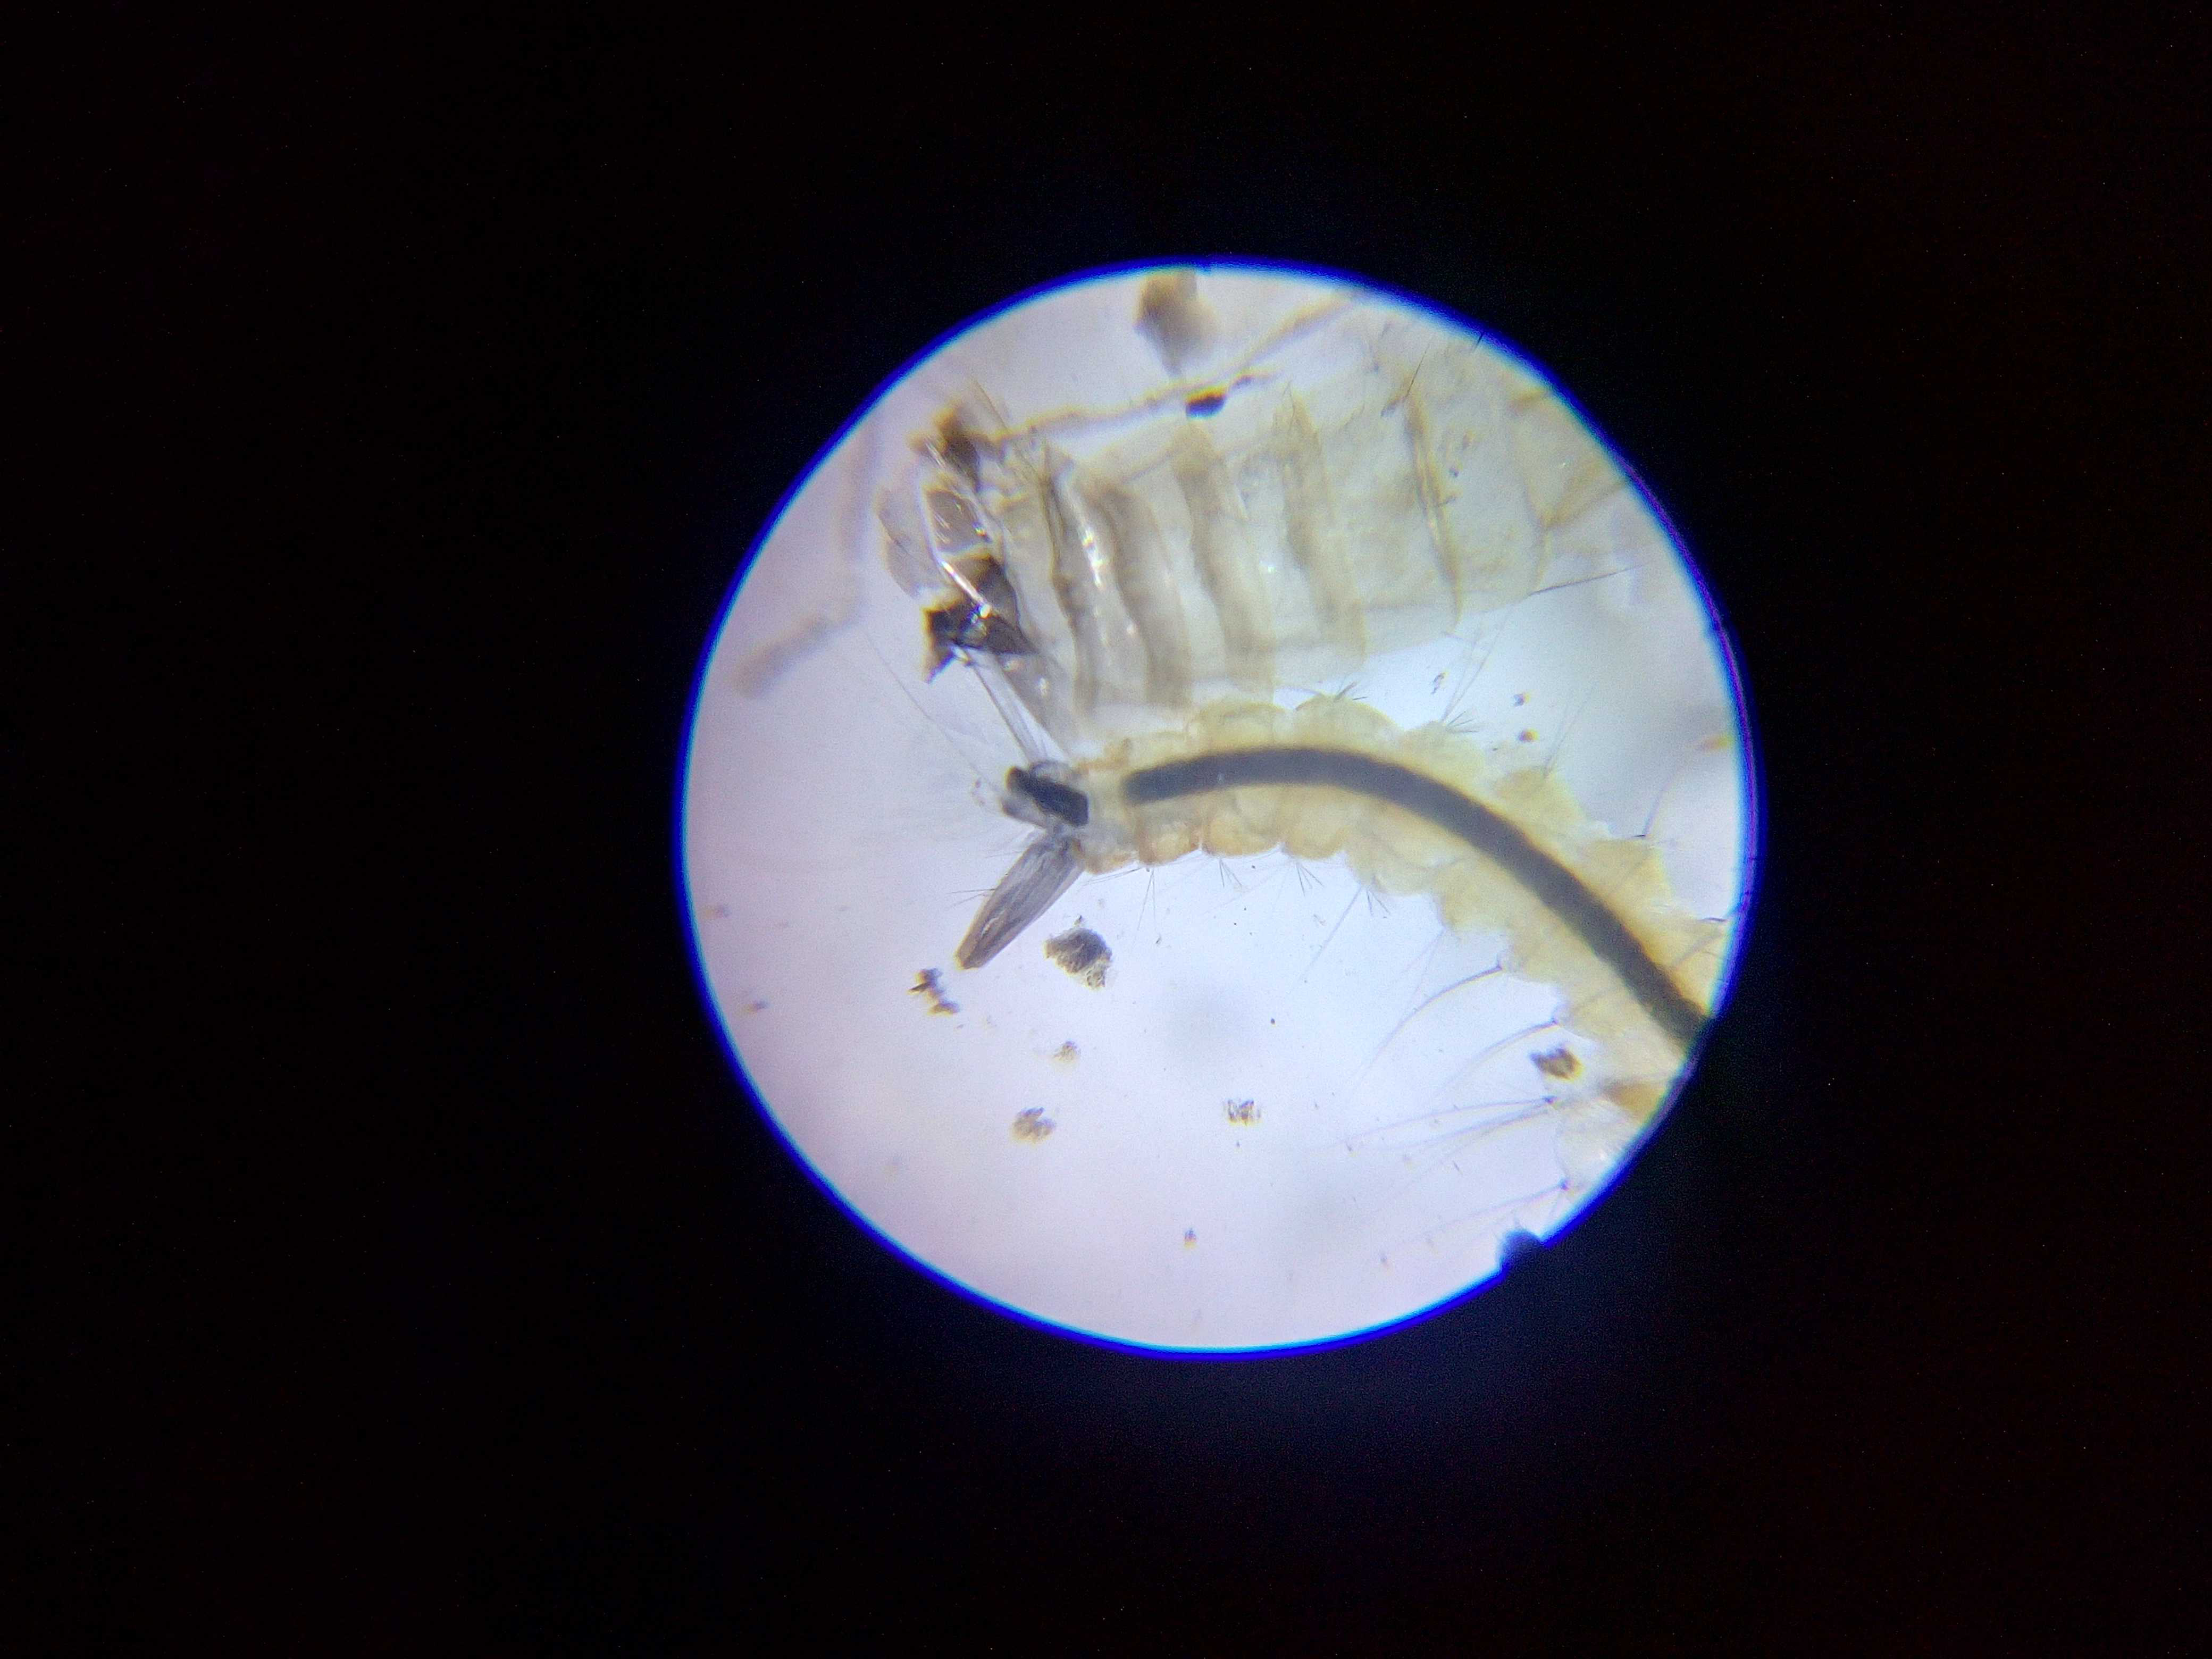

In [3]:
dataset['train'][0]['Photo']

In [3]:
from transformers import ViTFeatureExtractor
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [4]:
dataset = dataset.class_encode_column('Classification')

Parameter 'function'=<function Dataset.class_encode_column.<locals>.cast_to_class_labels at 0x000001FE6E5693A0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Casting to class labels:   0%|          | 0/8 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/4 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [5]:
dataset.features

AttributeError: 'DatasetDict' object has no attribute 'features'

In [5]:
dataset['train'].features

{'MHM Id': Value(dtype='float64', id=None),
 'Classification': ClassLabel(num_classes=3, names=['aedes', 'culex', 'neither'], id=None),
 'Container': Value(dtype='string', id=None),
 'Userid': Value(dtype='int64', id=None),
 'latitude': Value(dtype='float64', id=None),
 'longitude': Value(dtype='float64', id=None),
 'date': Value(dtype='string', id=None),
 'Photo': Image(decode=True, id=None)}

In [6]:
dataset = dataset.rename_column('Classification', 'labels')

In [7]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['Photo']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [8]:
prepared_ds = dataset.with_transform(transform)

In [9]:
prepared_ds['test'].features

{'MHM Id': Value(dtype='float64', id=None),
 'labels': ClassLabel(num_classes=3, names=['aedes', 'culex', 'neither'], id=None),
 'Container': Value(dtype='string', id=None),
 'Userid': Value(dtype='int64', id=None),
 'latitude': Value(dtype='float64', id=None),
 'longitude': Value(dtype='float64', id=None),
 'date': Value(dtype='string', id=None),
 'Photo': Image(decode=True, id=None)}

In [10]:
from transformers import default_data_collator

data_collator = default_data_collator

In [11]:
from transformers import ViTForImageClassification
labels = dataset['train'].features['labels'].names
#print(len(labels))
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels)
)

model.train()

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_fea

In [12]:
from datasets import load_metric
import numpy as np


def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")
  

    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = metric1.compute(predictions=predictions, references=labels, average="weighted")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="weighted")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-mosquito",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)

In [15]:
prepared_ds['train'].features['labels']

ClassLabel(num_classes=3, names=['aedes', 'culex', 'neither'], id=None)

In [16]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

C:\Users\Aswin.Surya24\Anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7107
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1780


***** Running Evaluation *****
  Num examples = 3439
  Batch size = 8


C:\Users\Aswin.Surya24\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ./vit-base-mosquito\checkpoint-100
Configuration saved in ./vit-base-mosquito\checkpoint-100\config.json
Model weights saved in ./vit-base-mosquito\checkpoint-100\pytorch_model.bin
Feature extractor saved in ./vit-base-mosquito\checkpoint-100\preprocessor_config.json
***** Running Evaluation *****
  Num examples = 3439
  Batch size = 8
Saving model checkpoint to ./vit-base-mosquito\checkpoint-200
Configuration saved in ./vit-base-mosquito\checkpoint-200\config.json
Model weights saved in ./vit-base-mosquito\checkpoint-200\pytorch_model.bin
Feature extractor saved in ./vit-base-mosquito\checkpoint-200\preprocessor_config.json
***** Running Evaluation *****

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 2051668264GF
  train_loss               =       0.4568
  train_runtime            =  19:55:24.41
  train_samples_per_second =        0.396
  train_steps_per_second   =        0.025


In [17]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 3439
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.6374
  eval_f1                 =     0.5868
  eval_loss               =     0.7836
  eval_precision          =     0.6061
  eval_recall             =     0.6374
  eval_runtime            = 0:40:29.67
  eval_samples_per_second =      1.415
  eval_steps_per_second   =      0.177
